# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [1]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [2]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [4]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Earth = Physics.Environment.Objects.CelestialBodies.Earth
Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Access

### Computation

Create a Two-Line Element (TLE) set:

In [5]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

Setup a SGP4 orbital model:

In [6]:
sgp4_model = Orbit.Models.SGP4(tle)

Setup the orbit:

In [7]:
to_orbit = Orbit(sgp4_model)

Now that the orbit is set, we can compute the access:

In [67]:
environment = Physics.Environment.Default() ;

access_generator = Access.Generator(environment) ;

start_instant = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime(2018, 1, 2, 0, 0, 0), Scale.UTC) ;
interval = Interval.Closed(start_instant, end_instant) ;

lla = LLA(Angle.Degrees(0.0), Angle.Degrees(0.0), Length.Meters(0.0))

from_trajectory = Trajectory.Position(Position.Meters(lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())) ;
to_trajectory = to_orbit ;

accesses = access_generator.computeAccesses(interval, from_trajectory, to_trajectory) ;

RuntimeError: Quaternion with norm [1] is not unitary.

In [ ]:
accesses

In [58]:
def lla_state (state):
    
    lla = LLA.Cartesian(state.accessPosition().getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)
    
    return [float(lla.getLatitude().inDegrees()), float(lla.getLongitude().inDegrees()), float(lla.getAltitude().inMeters())]

def access_geometry (access):
    
    return [lla_state(state) for state in to_trajectory.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))]

In [59]:
access_geometries = [access_geometry(access) for access in accesses]

In [60]:
access_geometry_dfs = [pd.DataFrame(access_geometry, columns=['Latitude', 'Longitude', 'Altitude']) for access_geometry in access_geometries]

In [62]:
access_geometry_dfs[0].head()

,Latitude,Longitude,Altitude
0,-16.953838,117.628604,407644.481195
1,-13.959361,120.217650,406965.329586
2,-10.936986,122.740809,406375.664235
3,-7.893324,125.213541,405883.797656
4,-5.702406,126.962857,405595.197122


### Output

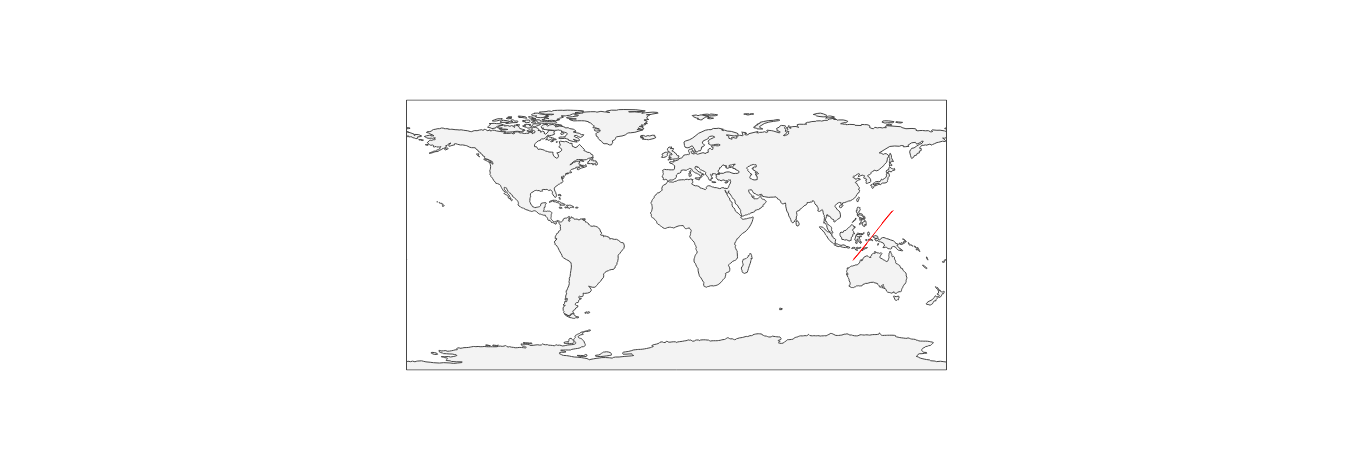

In [65]:
access_paths = []

for access_geometry_df in access_geometry_dfs:
    
    access_paths.append(
        dict(
            type = 'scattergeo',
#             locationmode = 'USA-states',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            )
        )
    )
    
layout = dict(
        title = None,
        showlegend = False, 
        geo = dict(
#             scope='north america',
#             projection=dict( type='azimuthal equal area' ),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=access_paths, layout=layout)
iplot(fig)